In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 2. Load dataset
CSV_PATH = 'tripadvisor_hotel_reviews.csv'
df2 = pd.read_csv(CSV_PATH)
print('Shape:', df2.shape)
print('Columns:', df2.columns.tolist())

df = df2[0:1000]


Shape: (20491, 2)
Columns: ['Review', 'Rating']


In [4]:
# 3. Basic preprocessing
# Try to detect review and rating columns
review_col = [c for c in df.columns if 'review' in c.lower() or 'text' in c.lower()][0]
rating_col = [c for c in df.columns if 'rating' in c.lower() or 'score' in c.lower()][0]


df = df[[review_col, rating_col]].dropna()

In [5]:
# Convert ratings to binary sentiment
# Positive (>=4) -> 1, Negative (<=2) -> 0, drop neutral


df = df[df[rating_col] != 3]
df['label'] = df[rating_col].apply(lambda x: 1 if x >= 4 else 0)


df = df.rename(columns={review_col: 'text'})[['text', 'label']]
print(df.head())
print('\nLabel distribution:\n', df['label'].value_counts())


# %%
# 4. Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42, stratify=df['label']
)

                                                text  label
0  nice hotel expensive parking got good deal sta...      1
1  ok nothing special charge diamond member hilto...      0
3  unique, great stay, wonderful time hotel monac...      1
4  great stay great stay, went seahawk game aweso...      1
5  love monaco staff husband stayed hotel crazy w...      1

Label distribution:
 label
1    645
0    218
Name: count, dtype: int64


In [6]:
# 5. Tokenization
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)


train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)


# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
dict(train_encodings), train_labels
)).batch(16)


test_dataset = tf.data.Dataset.from_tensor_slices((
dict(test_encodings), test_labels
)).batch(16)

c:\Users\LENOVO\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
# 6. Build and compile model
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')


model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# 7. Train model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=2)

Epoch 1/2

44/44 [==============================] - 596s 13s/step - loss: 0.5110 - accuracy: 0.7565 - val_loss: 0.2745 - val_accuracy: 0.9133
Epoch 2/2
44/44 [==============================] - 474s 11s/step - loss: 0.2190 - accuracy: 0.9188 - val_loss: 0.1829 - val_accuracy: 0.9306


11/11 [==============================] - 43s 3s/step

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.98      0.88        44
           1       0.99      0.91      0.95       129

    accuracy                           0.93       173
   macro avg       0.89      0.95      0.91       173
weighted avg       0.94      0.93      0.93       173



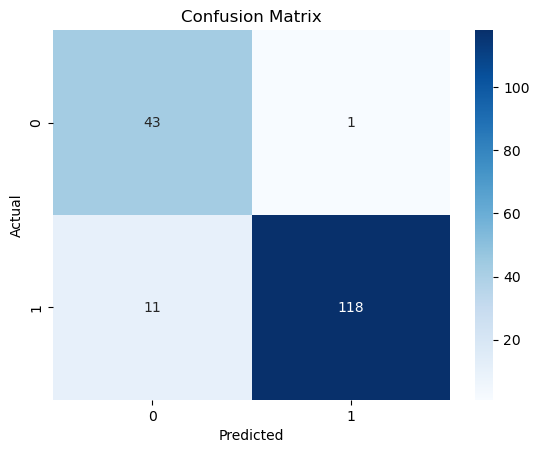

In [9]:
preds = model.predict(test_dataset).logits
pred_labels = np.argmax(preds, axis=1)


print("\nClassification Report:\n", classification_report(test_labels, pred_labels))


cm = confusion_matrix(test_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
history_dict = history.history

{'loss': [0.5110172033309937, 0.21900351345539093],
 'accuracy': [0.7565217614173889, 0.9188405871391296],
 'val_loss': [0.27454042434692383, 0.18288512527942657],
 'val_accuracy': [0.913294792175293, 0.9306358098983765]}